In [46]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Ścieżki do danych
base_dir = os.path.join(os.getcwd())  
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [ ]:
#Wczytanie danych
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32
)

Found 12000 files belonging to 120 classes.
Found 8580 files belonging to 120 classes.


In [ ]:
# Klasy i liczba klas
class_names = train_images.class_names
ile_clas = len(class_names)
print("Klasy:", class_names)
print("Liczba klas:", ile_clas)

Klasy: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-York

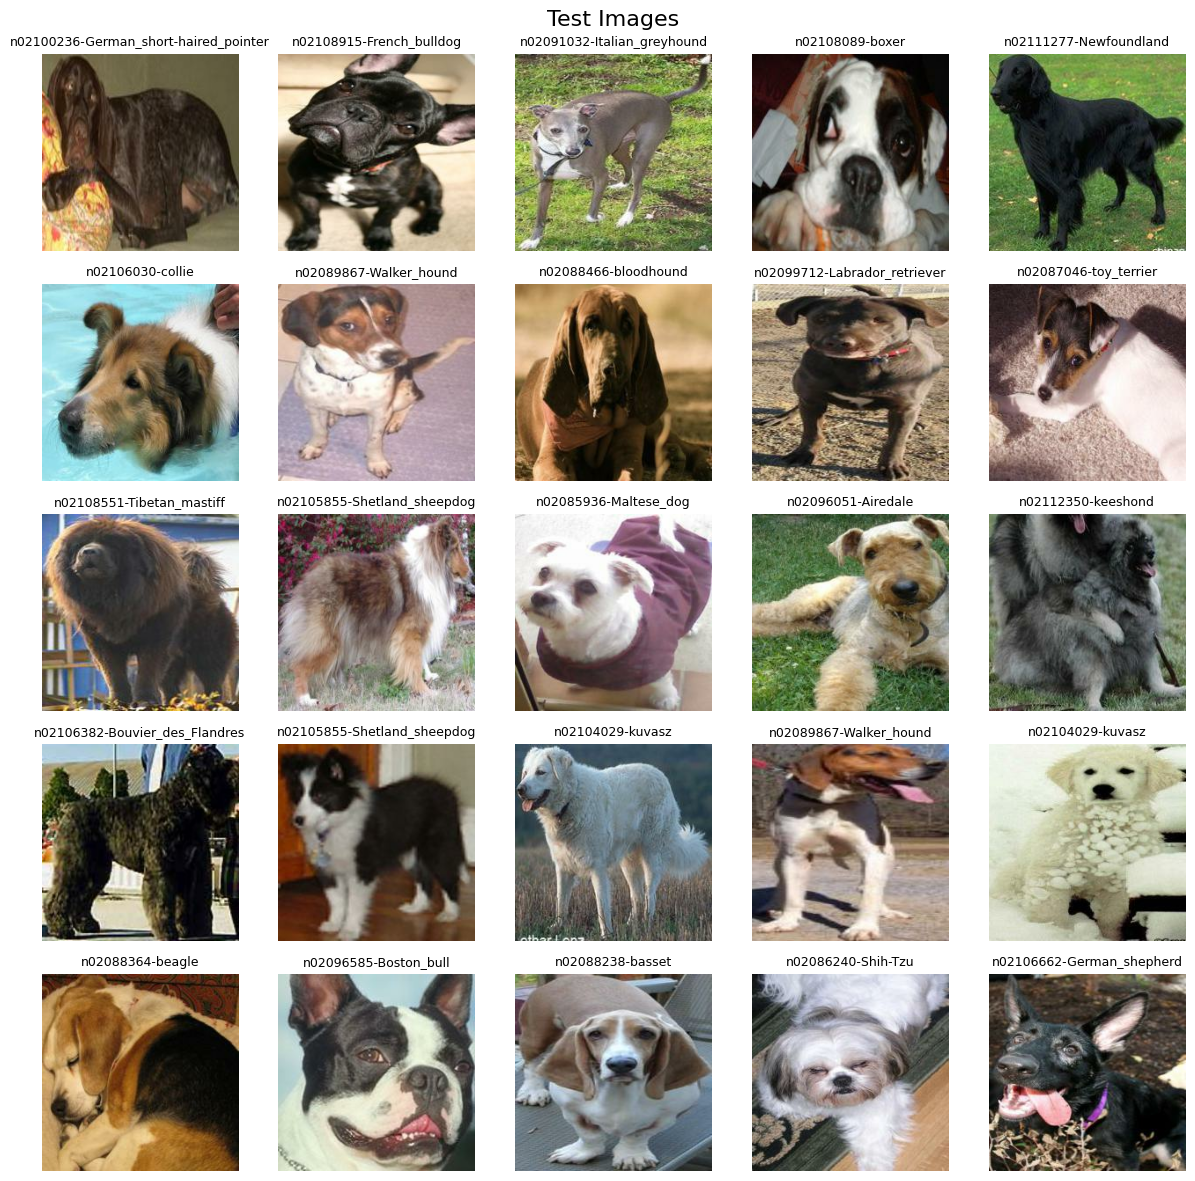

In [50]:
for images, labels in test_images.take(1):
    plt.figure(figsize=(12, 12))
    for i in range(min(25, len(images))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(f"{class_names[labels[i].numpy()]}", fontsize=9)
        plt.axis("off")
    plt.suptitle("Test Images", fontsize=16)
    plt.tight_layout()
    plt.show()

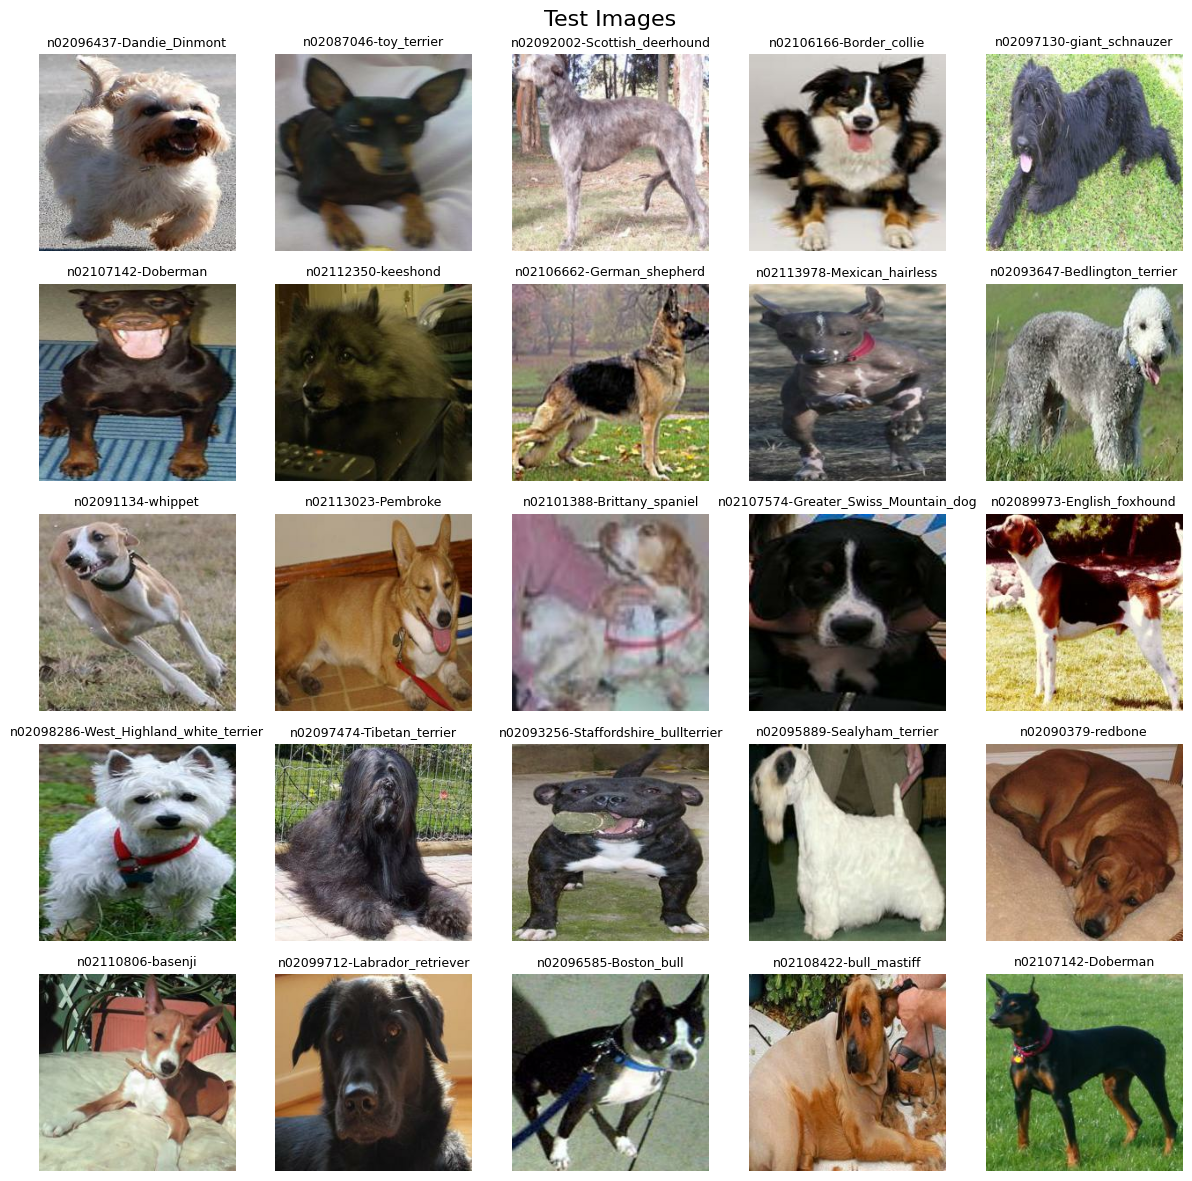

In [51]:

for images, labels in train_images.take(1):
    plt.figure(figsize=(12, 12))
    for i in range(min(25, len(images))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(f"{class_names[labels[i].numpy()]}", fontsize=9)
        plt.axis("off")
    plt.suptitle("Test Images", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# Normalizacja danych i shuffle/prefetch
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_images = train_images.map(lambda x, y: (normalization_layer(x), y))
test_images = test_images.map(lambda x, y: (normalization_layer(x), y))


In [53]:
class SoftRandomContrast(tf.keras.layers.Layer):
    def __init__(self, strength=0.01, prob=1.0, **kwargs):
        super().__init__(**kwargs)
        self.strength = strength
        self.prob = prob

    def call(self, images, training=True):
        def apply_contrast():
            contrast_factor = tf.random.uniform([], 1 - self.strength, 1 + self.strength)
            mean = tf.reduce_mean(images, axis=[1, 2], keepdims=True)
            return tf.clip_by_value((images - mean) * contrast_factor + mean, 0.0, 1.0)

        def skip():
            return images

        return tf.cond(
            tf.logical_and(training, tf.random.uniform([]) < self.prob),
            apply_contrast,
            skip
        )

In [54]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.10),
    tf.keras.layers.RandomZoom(0.10),
    SoftRandomContrast(strength=0.8, prob=0.5)  
])

In [55]:
# === MODEL ===
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
   data_augmentation,

    # Block 1
    tf.keras.layers.Conv2D(32, 3, padding='same'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),

    # Block 2
    tf.keras.layers.Conv2D(64, 3, padding='same'),
     tf.keras.layers.Dropout(0.10),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),

    # Block 3
    tf.keras.layers.Conv2D(128, 3, padding='same'),
   
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(ile_clas, activation='softmax')
])



model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,954,168 (49.42 MB)

 Trainable params: 12,954,040 (49.42 MB)

 Non-trainable params: 128 (512.00 B)

In [56]:
# 1. Pobierz jeden batch z train_images
example_batch = next(iter(train_images))
images, labels = example_batch

# 2. Przepuść przez augmentację
augmented_images = data_augmentation(images)


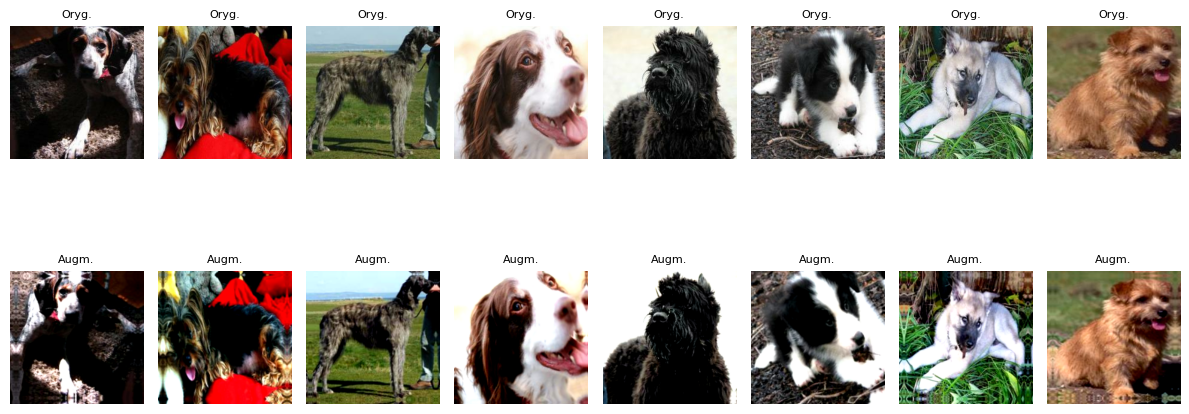

In [57]:
plt.figure(figsize=(12, 6))
for i in range(8):
    # Oryginał
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(images[i].numpy())
    plt.title("Oryg.", fontsize=8)
    plt.axis("off")

    # Augmentacja
    ax = plt.subplot(2, 8, i + 9)
    aug = augmented_images[i].numpy()
    if aug.max() > 1.0:
        aug = aug.astype("uint8") * 255.0
    plt.imshow(aug)
    plt.title("Augm.", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# === Kompilacja ===
model.compile(
    optimizer='adamax',
    loss='sparse_categorical_crossentropy',  # BO etykiety są liczbowe
    metrics=['accuracy']
)

# === Early stopping ===
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

# === Trening ===
history = model.fit(
    train_images,
    validation_data=test_images,
    epochs=80,
    callbacks=[early_stop]
)


Epoch 1/80


375/375 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.0104 - loss: 5.7353 - val_accuracy: 0.0206 - val_loss: 4.7353
Epoch 2/80
375/375 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.0226 - loss: 4.5996 - val_accuracy: 0.0268 - val_loss: 4.5172
Epoch 3/80
375/375 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.0273 - loss: 4.5060 - val_accuracy: 0.0351 - val_loss: 4.4565
Epoch 4/80
375/375 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.0259 - loss: 4.4856 - val_accuracy: 0.0346 - val_loss: 4.4367
Epoch 5/80
375/375 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.0330 - loss: 4.4581 - val_accuracy: 0.0354 - val_loss: 4.4236
Epoch 6/80
375/375 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.0363 - loss: 4.4294 - val_accuracy: 0.0420 - val_loss: 4.4176
Epoch 7/80
375/375 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.0349 - loss: 4.4135 - val_accuracy: 0.0351 - val_loss: 4.4259
Epoch 8/80
375/375 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.0357 - loss: 4.4061 - val_accuracy: 0.042

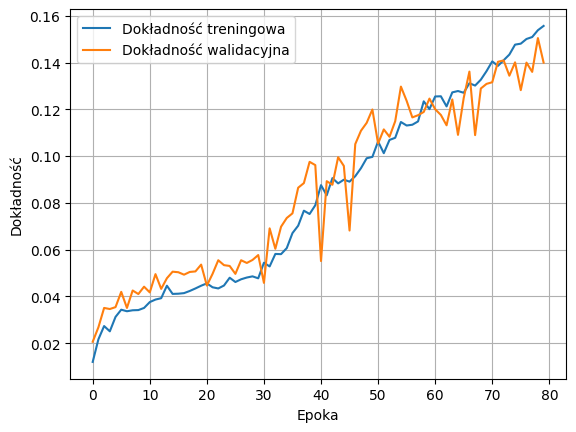

In [59]:
# === Wykres dokładności ===
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
# === Predykcje na testowych ===
images, labels = next(iter(test_images))
preds = model.predict(images)
predicted_classes = np.argmax(preds, axis=1)
true_classes = labels.numpy().astype("int32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


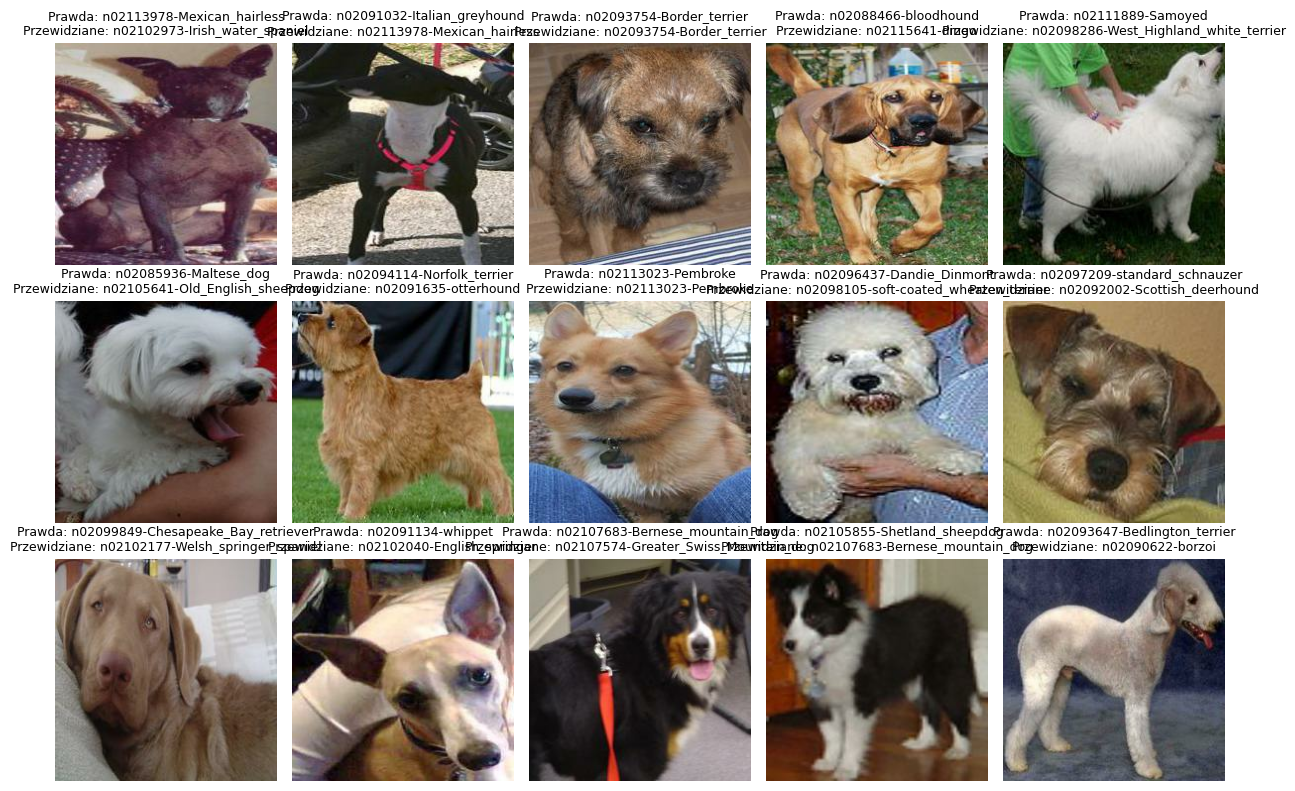

In [61]:
# === Pokazanie wyników ===
plt.figure(figsize=(12, 8))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")
    true_label = class_names[true_classes[i]]
    pred_label = class_names[predicted_classes[i]]
    ax.set_title(f"Prawda: {true_label}\nPrzewidziane: {pred_label}", fontsize=9)

plt.tight_layout()
plt.show()